In [5]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import re, sys, datetime, json, random, cv2, os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
from PIL import Image

Dusty                  : 100%|██████████████████████████████████████████| 1069/1069 [00:20<00:00, 51.01file/s]


2562 images were found in the dataset.
2049 for training, 513 for validation
average image height=  892   average image width=  1059  aspect ratio h/w=  0.842304060434372


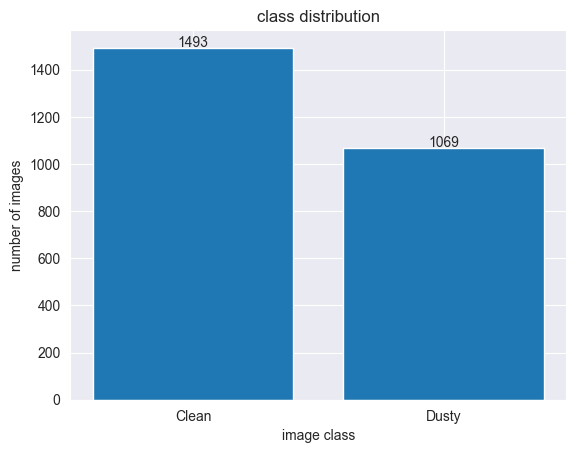

In [14]:
root = 'C:/Users/FurkanBulut/PycharmProjects/SolarVizyon/datasets/Detect_solar_dust'

def read_split_data(root, plot_image=False):
    filepaths = []
    labels = []
    bad_images = []

    random.seed(0)
    assert os.path.exists(root), 'wdnmd, 你tm路径不对啊!'

    classes = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    classes.sort()
    class_indices = {k: v for v, k in enumerate(classes)}

    json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)

    with open('classes_indices.json', 'w') as json_file:
        json_file.write(json_str)

    every_class_num = []
    supported = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']

    for klass in classes:
        classpath = os.path.join(root, klass)
        images = [os.path.join(root, klass, i) for i in os.listdir(classpath) if os.path.splitext(i)[-1] in supported]
        every_class_num.append(len(images))
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index:]
            if ext in supported:
                try:
                    img = cv2.imread(fpath)
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)

    train_df, test_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])

    train_image_path = train_df['filepaths'].tolist()
    val_image_path = test_df['filepaths'].tolist()

    train_image_label = [class_indices[i] for i in train_df['labels'].tolist()]
    val_image_label = [class_indices[i] for i in test_df['labels'].tolist()]

    sample_df = train_df.sample(n=50, replace=False)
    ht, wt, count = 0, 0, 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            ht += h
            wt += w
            count += 1
        except:
            pass
    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('{} images were found in the dataset.\n{} for training, {} for validation'.format(
        sum(every_class_num), len(train_image_path), len(val_image_path)
    ))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)

    if plot_image:
        plt.bar(range(len(classes)), every_class_num, align='center')
        plt.xticks(range(len(classes)), classes)

        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')

        plt.xlabel('image class')
        plt.ylabel('number of images')

        plt.title('class distribution')
        plt.show()

    return train_image_path, train_image_label, val_image_path, val_image_label, class_indices


train_image_path, train_image_label, val_image_path, val_image_label, class_indices = read_split_data(root, plot_image=True)

In [15]:
class MyDataset(Dataset):
    def __init__(self, image_path, image_labels, transform=None) -> None:
        super().__init__()
        self.image_path = image_path
        self.image_class = image_labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, item):
        img = Image.open(self.image_path[item]).convert('RGB')
        label = self.image_class[item]
        
        if self.transform is not None:
            img = self.transform(img)
        return img, label
    
    
    # DataLoader 方法会用到 如果不设置 则使用官方默认的
    @staticmethod
    def collate_fn(batch):
        images, labels = tuple(zip(*batch))
        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 8

data_transform = {
    'train': transforms.Compose([transforms.RandomResizedCrop(1024), transforms.ToTensor(), 
                                 transforms.RandomHorizontalFlip(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([transforms.Resize((1024, 1024)),
                                 transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}

train_dataset = MyDataset(train_image_path, train_image_label, data_transform['train'])
train_num = len(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=train_dataset.collate_fn)

valid_dataset = MyDataset(val_image_path, val_image_label, data_transform['valid'])
valid_num = len(valid_dataset)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=valid_dataset.collate_fn)

In [16]:
class BottleNeck(nn.Module):
    expansion = 4  

    def __init__(self, in_channels, out_channels, down_sample=None, stride=1, groups=1, width_per_group=64) -> None:
        super().__init__()

        width = int(out_channels * (width_per_group / 64)) * groups
        
        self.C1 = nn.Conv2d(in_channels, width, kernel_size=1, stride=1, bias=False)
        self.B1 = nn.BatchNorm2d(num_features=width)
        self.A1 = nn.ReLU(inplace=True)
        self.C2 = nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False)
        self.B2 = nn.BatchNorm2d(num_features=width)
        self.C3 = nn.Conv2d(width, out_channels*self.expansion, kernel_size=1, stride=1, bias=False)
        self.B3 = nn.BatchNorm2d(num_features=out_channels*self.expansion)
        self.down_sample = down_sample

    def forward(self, x):
        residual = x
        if self.down_sample is not None:
            residual = self.down_sample(x)
        x = self.C1(x)
        x = self.B1(x)
        x = self.A1(x)
        x = self.C2(x)
        x = self.B2(x)
        x = self.A1(x)
        x = self.C3(x)
        x = self.B3(x)
        y = x + residual
        y = self.A1(y)
        return y

In [17]:
class ResNet(nn.Module):
    def __init__(self, block, block_list, num_classes, groups=1, width_per_group=64) -> None:
        super().__init__()

        assert len(block_list) == 4

        self.initial_filters = 64
        self.groups = groups
        self.width_per_group = width_per_group

        self.C1 = nn.Conv2d(3, self.initial_filters, kernel_size=7, stride=2, padding=3, bias=False)
        self.B1 = nn.BatchNorm2d(num_features=self.initial_filters)
        self.A1 = nn.ReLU(inplace=True)
        self.P1 = nn.MaxPool2d(3, 2, padding=1)

        self.layer1 = self._make_layer(block, 64, block_list[0])
        self.layer2 = self._make_layer(block, 128, block_list[1], stride=2)
        self.layer3 = self._make_layer(block, 256, block_list[2], stride=2)
        self.layer4 = self._make_layer(block, 512, block_list[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.D1 = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')


    def _make_layer(self, block, channel, block_num, stride=1):
        down_sample = None

        if stride != 1 or self.initial_filters != channel * block.expansion:
            down_sample = nn.Sequential(
                nn.Conv2d(self.initial_filters, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(num_features=channel * block.expansion)
            )
            
        layers = []
        layers.append(block(self.initial_filters, channel, down_sample=down_sample, stride=stride, groups=self.groups,
                            width_per_group=self.width_per_group))
        
        self.initial_filters = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.initial_filters, channel, groups=self.groups,width_per_group=self.width_per_group))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.C1(x)
        x = self.B1(x)
        x = self.A1(x)
        x = self.P1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = torch.flatten(x, start_dim=1)
        y = self.D1(x)
        return y

In [18]:
net = ResNet(BottleNeck, [3, 4, 6, 3], num_classes=2).to(device)

initial_lr = 0.0003
epochs = 2
save_path = './Res50Model.pth'
best_val_acc = 0


if os.path.exists(save_path):
    print('----------------------loading----------------------')
    net.load_state_dict(torch.load(save_path))


optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr, weight_decay=0.0005)
loss_functions = nn.CrossEntropyLoss()


for epoch in range(epochs):
    running_loss = 0
    train_acc, val_acc = 0, 0
    
    net.train()
    train_bar = tqdm(train_loader, file=sys.stdout, colour='red')
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        outputs = net(images.to(device))
        loss = loss_functions(outputs, labels.to(device))
        running_loss += loss.item()
        train_acc += (torch.argmax(outputs, dim=1) == labels.to(device)).sum().item()
        loss.backward()
        optimizer.step()
        train_bar.desc = f'train epoch[{epoch+1} / {epochs}], loss{loss.item():.3f}'
    
    
    net.eval()
    with torch.no_grad():
        valid_bar = tqdm(valid_loader, file=sys.stdout, colour='red')
        for data in valid_bar:
            images, labels = data
            outputs = net(images.to(device))
            val_acc += (torch.argmax(outputs, dim=1) == labels.to(device)).sum().item()
            
    train_accuracy = train_acc / train_num        
    val_accuracy = val_acc / valid_num
    print(f'epoch[{epoch+1} / {epochs}] train_loss {(running_loss / train_num):.3f} train_accuracy: {train_accuracy:.3f} val_accuracy {val_accuracy:.3f}')
    
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(net.state_dict(), save_path)

  0%|          | 0/257 [00:43<?, ?it/s]


KeyboardInterrupt: 

In [11]:
try:
    json_file = open('./classes_indices.json', 'r')
    class_indict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

In [12]:
def predictor(testloader):
    errors = 0
    y_pred, y_true = [], []
    net = ResNet(BottleNeck, [3, 4, 6, 3], num_classes=2).to(device)
    net_weight_path = './Res50Model.pth'
    net.load_state_dict(torch.load(net_weight_path))
    
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            preds = torch.argmax(torch.softmax(net(images.to(device)), dim=0), dim=1)
            for i in range(len(preds)):
                y_pred.append(preds[i].cpu())
                y_true.append(labels[i].cpu())
                
    tests = len(y_pred)
    for i in range(tests):
        pred_index = y_pred[i]
        true_index = y_true[i]
        if pred_index != true_index:
            errors += 1
    acc = (1 - errors / tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%')
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    
    f1score = f1_score(ytrue, ypred, average='weighted') * 100
    print(f'The value of F1score was {f1score:.3f}')
    
    class_count = len(list(class_indict.values()))
    classes = list(class_indict.values())
    
    cm = confusion_matrix(ytrue, y_pred)
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(class_count) + .5, classes, rotation=90, fontsize=14)
    plt.yticks(np.arange(class_count) + .5, classes, rotation=0, fontsize=14)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.title("Confusion Matrix")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.1%')
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)
    
    return f1score


f1score = predictor(valid_loader)

FileNotFoundError: [Errno 2] No such file or directory: './Res50Model.pth'